In [16]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.cm as cm
from shapely.geometry import Polygon, mapping
import folium

# Data
# Found that all dv_related rows had NA values. Cleaned data removes important information.
BTVpolice = pd.read_csv('data/BTVpolice.csv')

In [3]:
BTVpolice.columns

Index(['incident_number', 'call_type', 'call_type_group', 'call_time',
       'Street', 'call_origin', 'mental_health', 'drug_related', 'dv_related',
       'alcohol_related', 'Area', 'AreaName', 'Latitude', 'Longitude', 'Hour',
       'DayOfWeek', 'priority', 'Month', 'ObjectId'],
      dtype='object')

## Try mapping by different factors

date
2015-09-04    173
2015-09-11    173
2015-09-25    170
2016-05-30    170
2016-05-06    168
dtype: int64


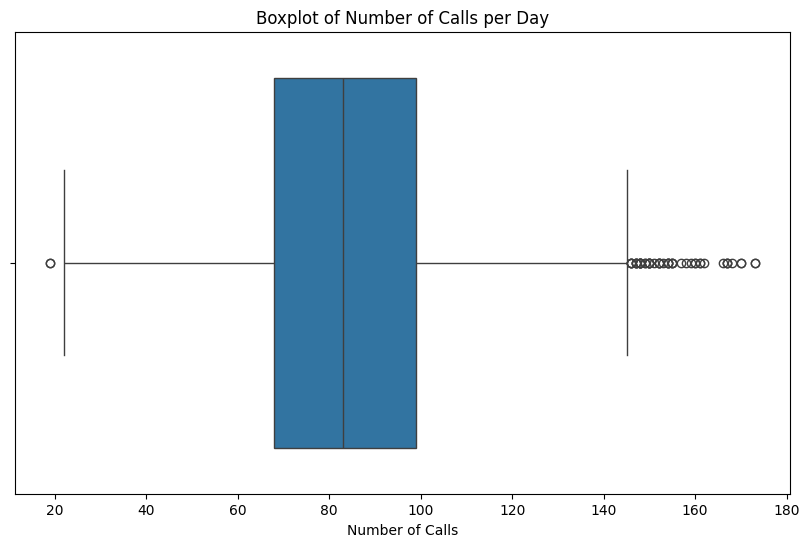

In [4]:
# Date
#Think about holidays/significant events
#Find outliers
BTVpolice['call_time'] = pd.to_datetime(BTVpolice['call_time'])
BTVpolice['date'] = BTVpolice['call_time'].dt.date
calls_per_day = BTVpolice.groupby('date').size()
mean_calls = calls_per_day.mean()
std_calls = calls_per_day.std()
outliers = calls_per_day[calls_per_day > (mean_calls + 2 * std_calls)]
outliers_sorted = outliers.sort_values(ascending = False)
print(outliers_sorted.head())

#Visualize outliers in boxplot
BTVpolice['call_time'] = pd.to_datetime(BTVpolice['call_time'])
BTVpolice['date'] = BTVpolice['call_time'].dt.date

calls_per_day = BTVpolice.groupby('date').size().reset_index(name='num_calls')

plt.figure(figsize=(10, 6))
sns.boxplot(x=calls_per_day['num_calls'])
plt.title('Boxplot of Number of Calls per Day')
plt.xlabel('Number of Calls')
plt.show()



Looking at the above dates, we can find that 7/14/2023 is the date with the most calls, and with a quick news search we can find that this was when flooding was a large problem in Burlington. Other outliers can likely be explained through similar reasons.

In [51]:


# Sample data for each priority level
priorities = [1, 2, 3]
colors = ['plasma', 'viridis', 'cividis']  # Different color maps for each priority level

# Initialize the main map
burlington_map = folium.Map(location=[44.4759, -73.2121], zoom_start=13)

# Function to generate geojson data for a specific priority level
def create_geojson_for_priority(priority, colormap_name):
    BTVpolice_priority = BTVpolice[BTVpolice['priority'] == f"Priority {priority}"]
    BTVpolice_priority_filtered = BTVpolice_priority.dropna(subset=['Latitude', 'Longitude'])

    x = BTVpolice_priority_filtered['Longitude'].values
    y = BTVpolice_priority_filtered['Latitude'].values

    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]

    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values, bw_method=0.02)
    density = np.reshape(kernel(positions).T, xx.shape)

    contour_levels = np.linspace(density.min() + 0.0001, density.max(), 40)
    features = []

    colormap = cm.get_cmap(colormap_name, len(contour_levels))

    # Create GeoJSON features based on density contours
    fig, ax = plt.subplots()
    contours = ax.contour(xx, yy, density, levels=contour_levels)
    for i, level in enumerate(contours.collections):
        color = colormap(i / len(contour_levels))
        for contour_path in level.get_paths():
            for segment in contour_path.to_polygons():
                poly = Polygon(segment)
                if poly.is_valid:
                    feature = {
                        "type": "Feature",
                        "geometry": mapping(poly),
                        "properties": {
                            "level": contour_levels[i],
                            "color": f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, 0.4)' 
                        }
                    }
                    features.append(feature)
    plt.close(fig)  # Close the figure after creating contours to free memory
    
    geojson_data = {
        "type": "FeatureCollection",
        "features": features
    }
    return geojson_data

# Add GeoJSON layers for each priority level to the map
for priority, colormap_name in zip(priorities, colors):
    geojson_data = create_geojson_for_priority(priority, colormap_name)
    
    folium.GeoJson(
        geojson_data,
        name=f'Priority {priority}',
        style_function=lambda feature: {
            "fillColor": feature["properties"]["color"],
            "color": "black",
            "weight": 0.1,
            "fillOpacity": 0.1  # Adjust opacity for map visibility
        }
    ).add_to(burlington_map)

# Add a layer control to toggle between priorities
folium.LayerControl().add_to(burlington_map)

burlington_map


/var/folders/05/b_dps8k90m5d6w0ttvf7hzg40000gn/T/ipykernel_1340/3499213977.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(colormap_name, len(contour_levels))
/var/folders/05/b_dps8k90m5d6w0ttvf7hzg40000gn/T/ipykernel_1340/3499213977.py:33: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for i, level in enumerate(contours.collections):
/var/folders/05/b_dps8k90m5d6w0ttvf7hzg40000gn/T/ipykernel_1340/3499213977.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(colormap_name, len(contour_levels))
/var/folders/05/b_d

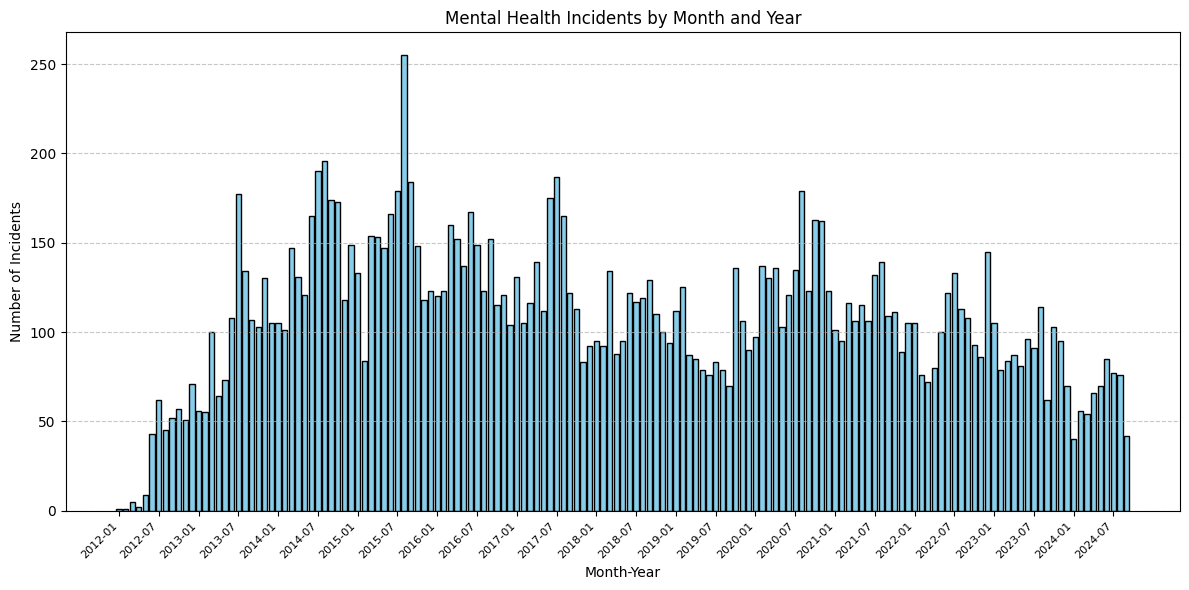

In [ ]:
## Mental Health

# Convert 'date' column to datetime if it's not already
BTVpolice['date'] = pd.to_datetime(BTVpolice['date'])

# Extract year and month from the 'date' column
BTVpolice['year'] = BTVpolice['date'].dt.year
BTVpolice['month'] = BTVpolice['date'].dt.month

# Group by year and month, and calculate the total number of mental health incidents
mental_health_by_month_year = BTVpolice.groupby(['year', 'month'])['mental_health'].sum().reset_index()

# Combine 'year' and 'month' into a single column for plotting
mental_health_by_month_year['month_year'] = mental_health_by_month_year['year'].astype(str) + '-' + mental_health_by_month_year['month'].astype(str).str.zfill(2)

# Create X-axis labels for every six months
ticks_to_show = range(0, len(mental_health_by_month_year), 6)  # Every 6th label

# Plot as a histogram
plt.figure(figsize=(12, 6))
plt.bar(mental_health_by_month_year['month_year'], mental_health_by_month_year['mental_health'], color='skyblue', edgecolor='black')
plt.title('Mental Health Incidents by Month and Year')
plt.xlabel('Month-Year')
plt.ylabel('Number of Incidents')
plt.xticks(ticks=ticks_to_show, labels=mental_health_by_month_year['month_year'].iloc[ticks_to_show], rotation=45, ha='right', fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


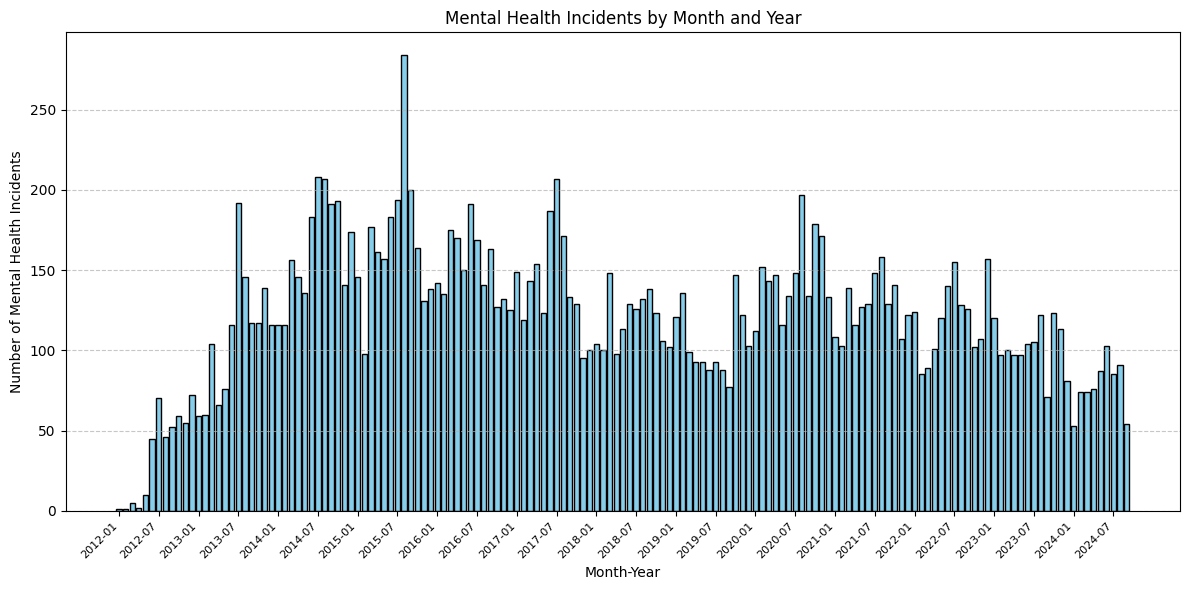

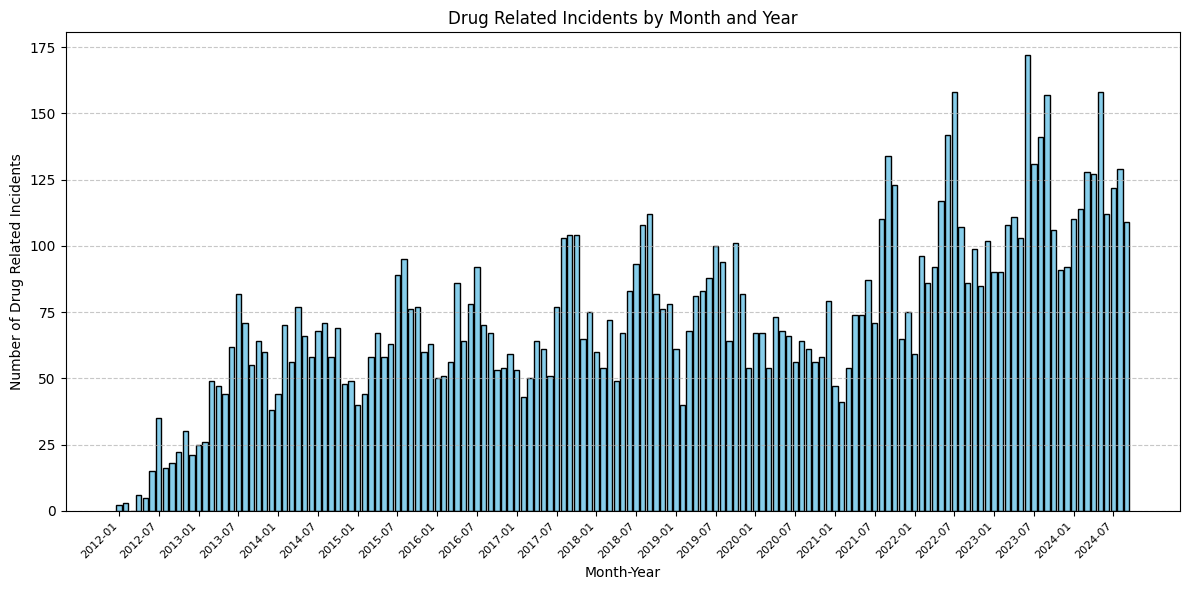

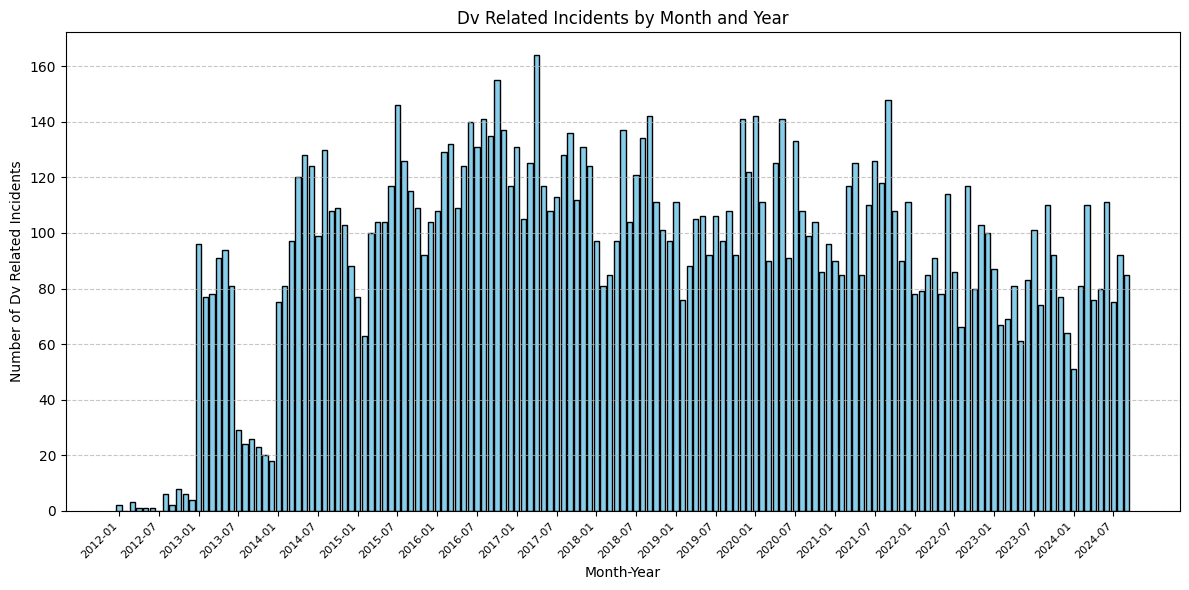

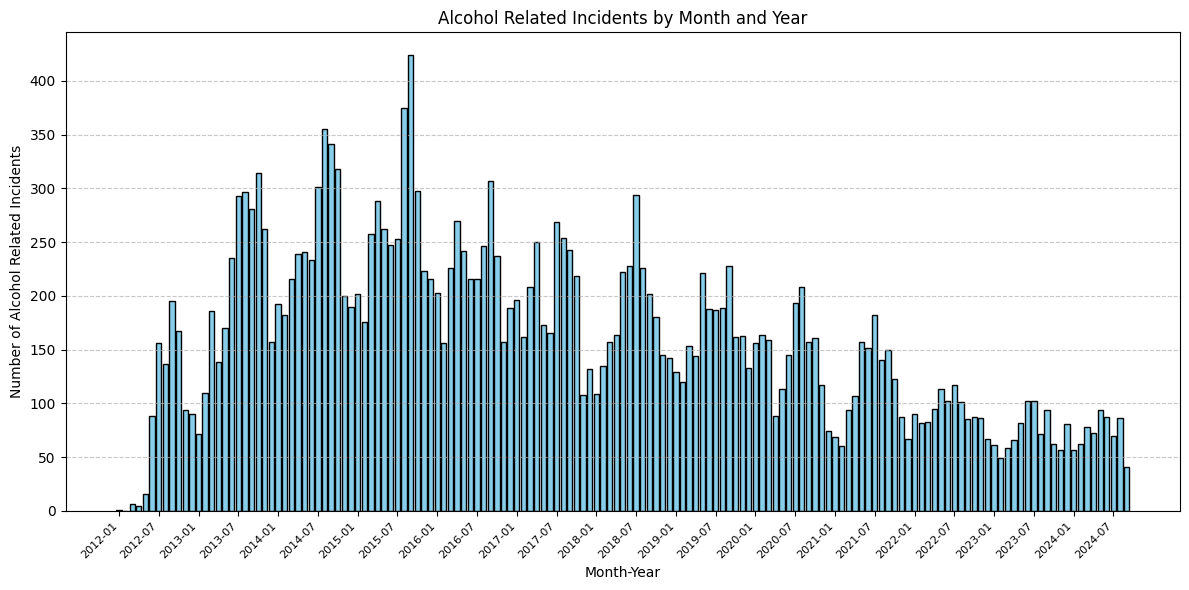

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the dataset is already loaded as BTVpolice

# Convert 'date' column to datetime if it's not already
BTVpolice['date'] = pd.to_datetime(BTVpolice['date'])

# Extract year and month from the 'date' column
BTVpolice['year'] = BTVpolice['date'].dt.year
BTVpolice['month'] = BTVpolice['date'].dt.month

# Categories to plot
categories = ['mental_health', 'drug_related', 'dv_related', 'alcohol_related']

# Group by year and month
data_by_month_year = BTVpolice.groupby(['year', 'month'])[categories].sum().reset_index()

# Combine year and month for easier plotting
data_by_month_year['month_year'] = (
    data_by_month_year['year'].astype(str) + '-' + data_by_month_year['month'].astype(str).str.zfill(2)
)

# Define the X-axis ticks to show every six months
ticks_to_show = range(0, len(data_by_month_year), 6)  # Every 6th label

# Plot each category
for category in categories:
    plt.figure(figsize=(12, 6))
    plt.bar(data_by_month_year['month_year'], data_by_month_year[category], color='skyblue', edgecolor='black')
    plt.title(f'{category.replace("_", " ").title()} Incidents by Month and Year')
    plt.xlabel('Month-Year')
    plt.ylabel(f'Number of {category.replace("_", " ").title()} Incidents')
    plt.xticks(ticks=ticks_to_show, 
               labels=data_by_month_year['month_year'].iloc[ticks_to_show], 
               rotation=45, 
               ha='right', 
               fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


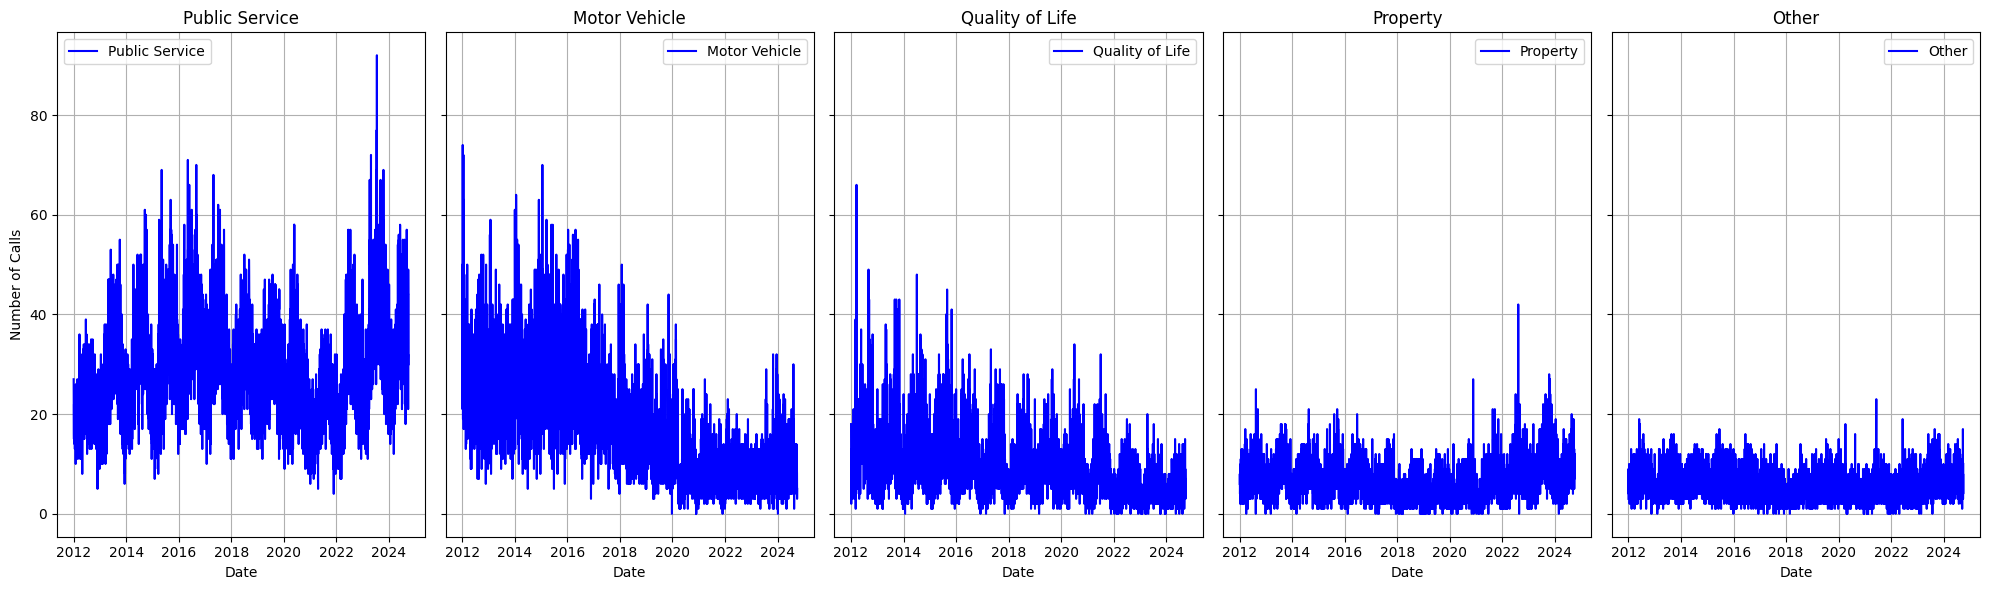

In [ ]:
# Call_type
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the dataset is already loaded as BTVpolice

# Convert 'date' column to datetime if it's not already
BTVpolice['date'] = pd.to_datetime(BTVpolice['date'])

# Find the top 5 most frequent call_type_group categories
top_5_call_types = BTVpolice['call_type_group'].value_counts().head(5).index

# Filter dataset to include only the top 5 call_type_group categories
filtered_data = BTVpolice[BTVpolice['call_type_group'].isin(top_5_call_types)]

# Group by 'date' and 'call_type_group' and count occurrences
call_type_counts = filtered_data.groupby(['date', 'call_type_group']).size().unstack(fill_value=0)

# Plot all top 5 call_type_groups side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharey=True)

# Iterate over each of the top 5 call types and plot
for i, call_type in enumerate(top_5_call_types):
    axes[i].plot(call_type_counts.index, call_type_counts[call_type], label=call_type, color='blue')
    axes[i].set_title(call_type)
    axes[i].set_xlabel('Date')
    if i == 0:  # Only the first subplot has a Y-axis label
        axes[i].set_ylabel('Number of Calls')
    axes[i].grid(True)
    axes[i].legend()

# Adjust layout for better readability
plt.tight_layout()
plt.show()


In [57]:
# Create an empty array to store unique 10-character strings
unique_dates = []
count = 0
# Iterate over each value in the 'Hour' column
for timestamp in BTVpolice['call_time']:
    # Extract the first 10 characters of the timestamp
    date_str = timestamp[:10]  # Get first 10 characters
    # Add to the array only if it isn't already present
    if date_str not in unique_dates:
        unique_dates.append(date_str)
        count = count + 1

# Display the unique dates
print(count)
dates = count

4657


In [42]:
BTVpolice['DayOfWeek'].count

<bound method Series.count of 0         Wednesday
1         Wednesday
2         Wednesday
3         Wednesday
4         Wednesday
            ...    
392501       Sunday
392502       Sunday
392503    Wednesday
392504     Saturday
392505       Monday
Name: DayOfWeek, Length: 392506, dtype: object>

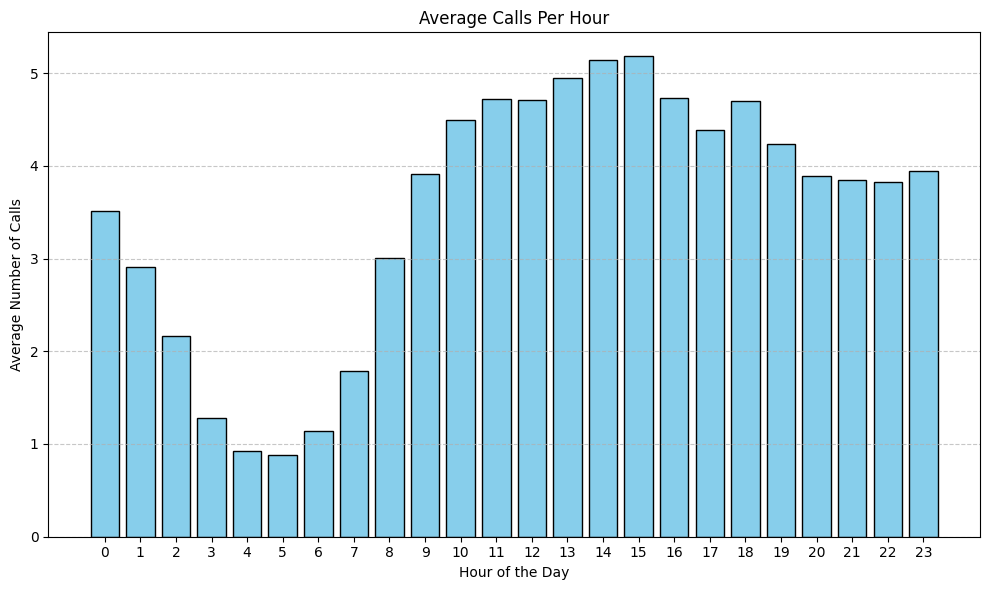

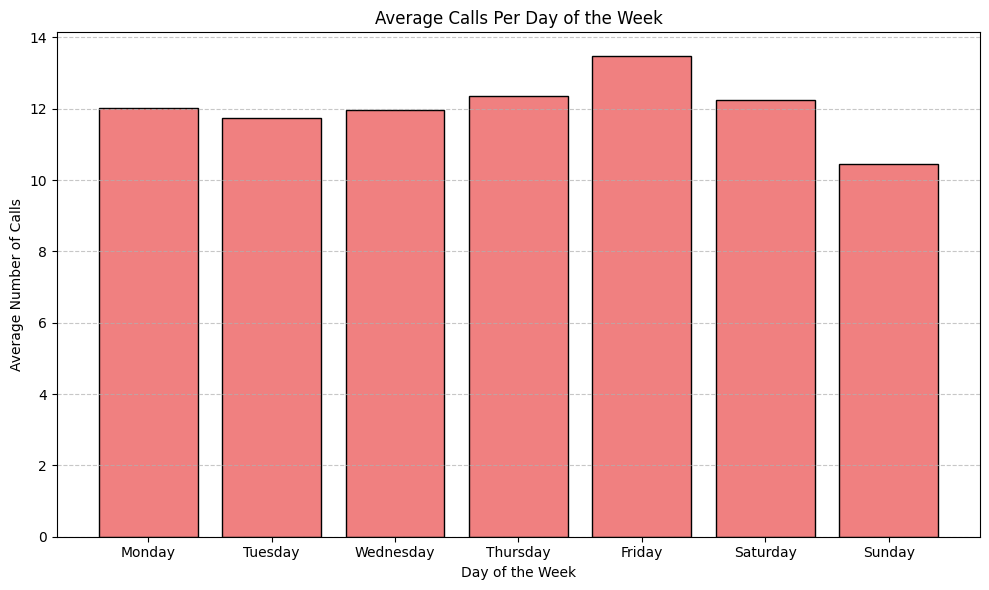

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'call_time' column to datetime
BTVpolice['call_time'] = pd.to_datetime(BTVpolice['call_time'], errors='coerce')

# Extract relevant parts from 'call_time'
BTVpolice['HourOnly'] = BTVpolice['call_time'].dt.hour  # Extract hour (0–23)
BTVpolice['DayOfWeek'] = BTVpolice['call_time'].dt.day_name()  # Extract day of the week
BTVpolice['Date'] = BTVpolice['call_time'].dt.date  # Extract date

# Calculate unique days in the dataset
total_days = BTVpolice['Date'].nunique()

# 1. Average calls per hour
hourly_counts = BTVpolice.groupby('HourOnly').size()
avg_calls_per_hour = hourly_counts / total_days

# Plot average calls per hour
plt.figure(figsize=(10, 6))
plt.bar(avg_calls_per_hour.index, avg_calls_per_hour.values, color='skyblue', edgecolor='black')
plt.title('Average Calls Per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Calls')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Average calls per day of the week
daily_counts = BTVpolice.groupby('DayOfWeek').size()
avg_calls_per_day = daily_counts / total_days

# Reorder days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_calls_per_day = avg_calls_per_day.reindex(day_order)

# Plot average calls per day of the week
plt.figure(figsize=(10, 6))
plt.bar(avg_calls_per_day.index, avg_calls_per_day.values, color='lightcoral', edgecolor='black')
plt.title('Average Calls Per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Calls')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


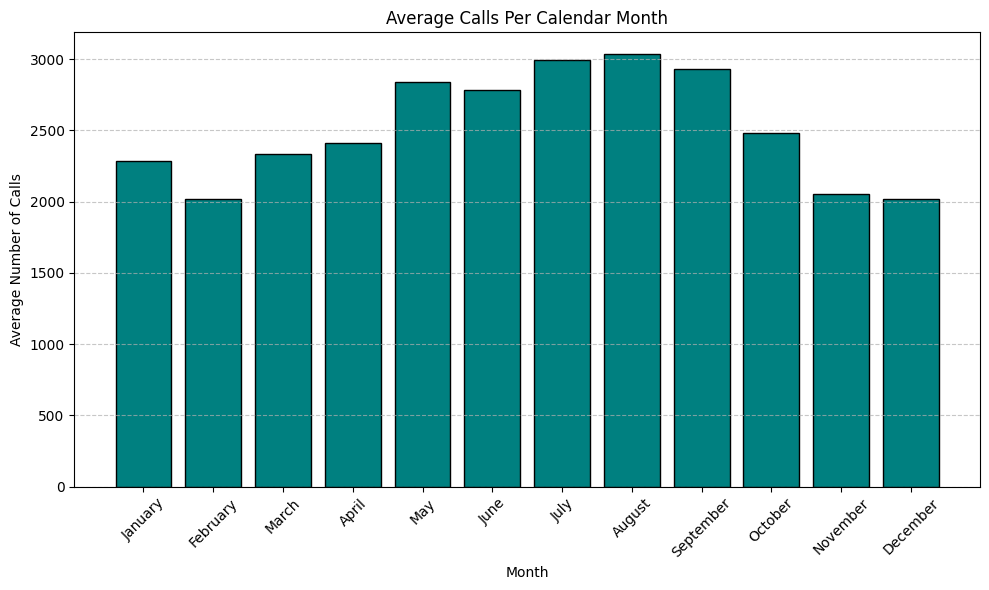

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'call_time' column to datetime
BTVpolice['call_time'] = pd.to_datetime(BTVpolice['call_time'], errors='coerce')

# Extract the month from 'call_time'
BTVpolice['Month'] = BTVpolice['call_time'].dt.month  # Extract month as an integer (1–12)

# Group by Month and calculate average calls
monthly_counts = BTVpolice.groupby('Month').size()
total_years = BTVpolice['call_time'].dt.year.nunique()  # Number of unique years in the dataset
avg_calls_per_calendar_month = monthly_counts / total_years

# Map month numbers to month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
avg_calls_per_calendar_month.index = [month_names[m-1] for m in avg_calls_per_calendar_month.index]

# Plot average calls per calendar month
plt.figure(figsize=(10, 6))
plt.bar(avg_calls_per_calendar_month.index, avg_calls_per_calendar_month.values, 
        color='teal', edgecolor='black')
plt.title('Average Calls Per Calendar Month')
plt.xlabel('Month')
plt.ylabel('Average Number of Calls')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [19]:

# Convert 'date' column to datetime if it's not already
BTVpolice['date'] = pd.to_datetime(BTVpolice['date'])

# Group by 'date' and 'priority', and count the number of calls
priority_counts = BTVpolice.groupby(['date', 'priority']).size().unstack(fill_value=0)

# Plot all three priorities side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Priority labels for titles
priorities = ['Priority 1', 'Priority 2', 'Priority 3']

for i, priority in enumerate(priorities):
    axes[i].plot(priority_counts.index, priority_counts[priority], label=priority, color='blue')
    axes[i].set_title(f'{priority} Calls Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Number of Calls' if i == 0 else '')  # Only first subplot has ylabel
    axes[i].grid(True)
    axes[i].legend()

# Adjust layout for readability
plt.tight_layout()
plt.show()


KeyError: 'date'

In [ ]:
## Look at data points with lowest X value and highest Y value, these are the ones showing in the water


# Find the row with the lowest X value
lowest_x_row = BTVpolice.loc[BTVpolice['X'].idxmin()]

# Find the row with the highest Y value
highest_y_row = BTVpolice.loc[BTVpolice['Y'].idxmax()]

print("Data point with the lowest X value:")
print(lowest_x_row)

print("\nData point with the highest Y value:")
print(highest_y_row)


Data point with the lowest X value:
X                            -8161816.637625
Y                             5552097.694176
incident_number                   24BU009166
call_type                Found/Lost Property
call_type_group               Public Service
call_time          2024-05-06 09:58:29+00:00
Street                             North Ave
call_origin                            Phone
mental_health                              0
drug_related                               0
dv_related                                 0
alcohol_related                            0
Area                                       A
AreaName                         NewNorthEnd
Latitude                            44.55732
Longitude                         -73.318846
Hour                  2024/09/06 09:00:00+00
DayOfWeek                             Monday
priority                          Priority 3
Month                                    May
ObjectId                              377775
date               